# Kaggle Titanic dataset

## Contents:

1. Importing and verifying the data
1. Exploring the data
1. Feature engineering
1. Model

In [77]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.feature_selection import SelectFromModel

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score

sns.set(style='white', context='notebook', palette='deep')
pd.options.display.max_columns = 100

We will be using Pandas and Numpy for data manipulation, Matplotlib and Seaborn for data visualisation, and SKlearn for training our classifiers.

# 1) Importing and verifying the data

## 1.1) Importing the data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## 1.2) Detecting outliers

In [3]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method. 
    The Tukey method (Tukey JW., 1977) defines an interquartile range comprised between 
    the 1st and 3rd quartile of the distribution values (IQR). 
    An outlier is a row that has a feature value outside the (IQR +- an outlier step).
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

# detect outliers from Age, SibSp , Parch and Fare
# These are the numerical features present in the dataset
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [4]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S


The Turkey outlier detection method found 10 outliers. 3 of these rows are outliers due to a high ticket price.
7 of these rows are outliers due to having a high amount of siblings. These rows will be dropped.

In [5]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

## 1.3) Creating a single dataset from train and test

In [6]:
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

## 1.4) Checking for NaN

In [7]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

The survived column contains 418 NaN because the test set did not have a "Survived" column, these NaN are simply the result of concatenating the two datasets.

"Embarked" and "Fare" have a negligible amount of NaN, we will be able to fill these with the median value without compromising the integrity of our dataset.

"Age" and "Cabin" will prove to be more problematic as a signficant amount of NaN are present.

In [8]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
### Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,NaN,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,NaN,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 2) Exploring the data

## 2.1) Numerical features

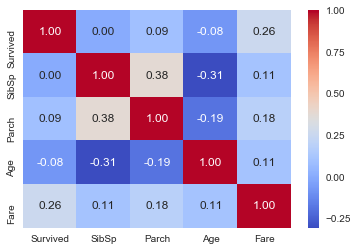

In [12]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

We can see that "Survived" is positively correlated with "Fare" and that is has low correlation to the other feautures.

"Age" is negatively correlated with SbSip and Parch, which is intuitive. Younger passengers are more likely to be travelling with their parents and siblings. Similarly, SbSip and Parch are positively correlated, indicating that families are likely to travel together.



## SibSp

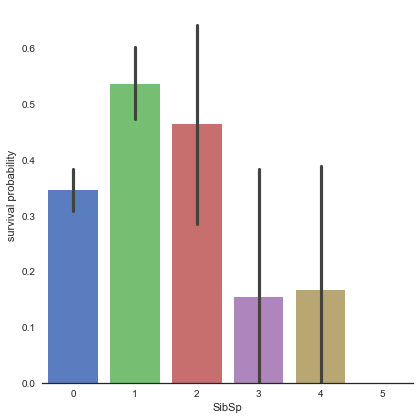

In [13]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Passengers with more than 2 siblings are significantly less likely to survive.

## Parch

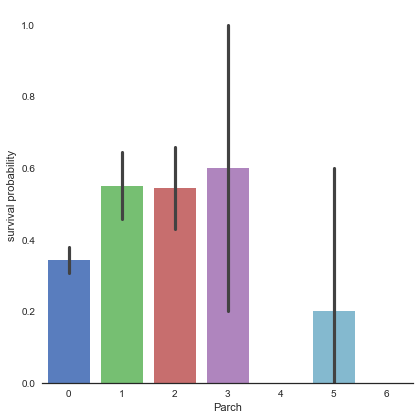

In [14]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Smaller families (1&2) are more likely to survive. 

## Age

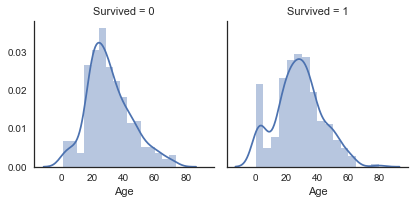

In [15]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

We can see that people aged between 20 and 40 are far less likely to survive. We can also see that very young children have high survival rates.

The distribution appears to be somewhat Gaussian, with skew.

Age was one of the variables with a high amount of NaN (256), this will have to be dealt with. Due to the high proportion, and the high correlation between Age and Survival rate we can't simply fill the NaN with the median.

We will have to estimate the age of a given passenger, age will be a function of our other variables.

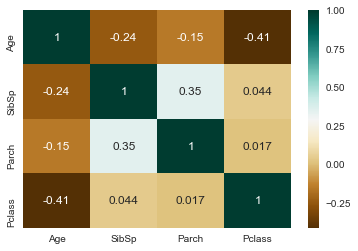

In [16]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

We can confirm that Age is not correlated with Sex. We will have to estimate Age based on the class and the presence of other family members.

In [17]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

Thus, the attributed Age is the median age of other passengers with a similar Sex, Class, number of siblings, and number of parents. If a similar passenger cannot be identified, the median age of the whole dataset is assigned.

## Fare

In [18]:
dataset["Fare"].isnull().sum()

1

In [19]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

As previously mentioned, the Fare variable contained one NaN. We have filled it with the median value.

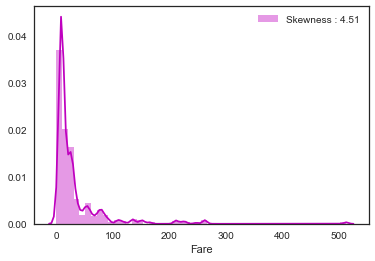

In [20]:
# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

Due to the high skew present in the data, it will need to be transformed and smoothed. 

In [21]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

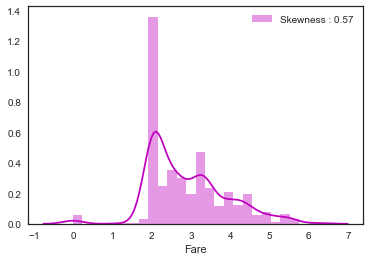

In [22]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

We can see that the log transformation has significantly reduced the skew.

## 2.2) Categorical features

## Sex

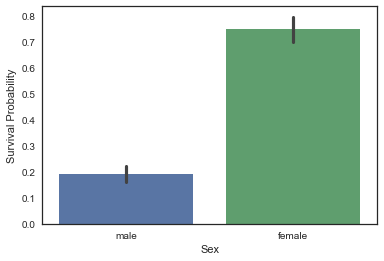

In [23]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

Women are far more likely to survive than men, this will likely be a strong predictor variable.

In [24]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

We have converted sex to a binary variable so that it can be used by our ML algorithms. 0 inidicates male, 1 indicates female.

## Pclass

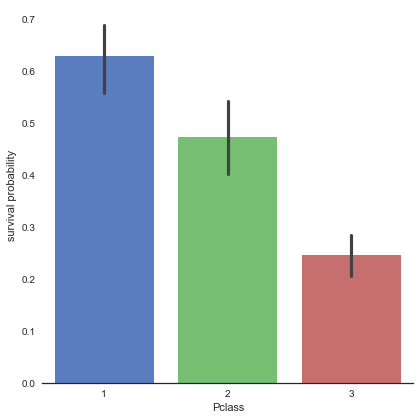

In [25]:


# Explore Pclass vs Survived
g = sns.factorplot(x="Pclass",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Pclass has a negative and almost perfectly linear correlation with survival probability. 

## Embarked

In [26]:
dataset["Embarked"].isnull().sum()

2

In [27]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

As previously mentioned, the Embarked variable contained two NaN. We have filled them with the median value.

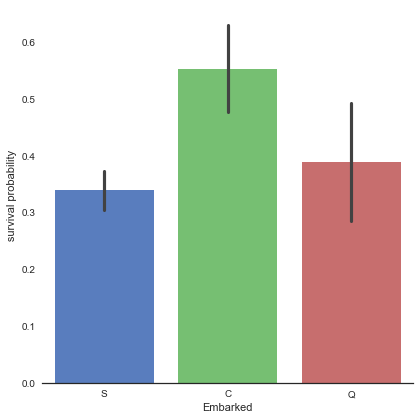

In [28]:
# Explore Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived",  data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Passengers embarking in C are far more likely to survive. It may be due to their position on the ship, or due to them being a more upscale clientele and placed in 1st class.

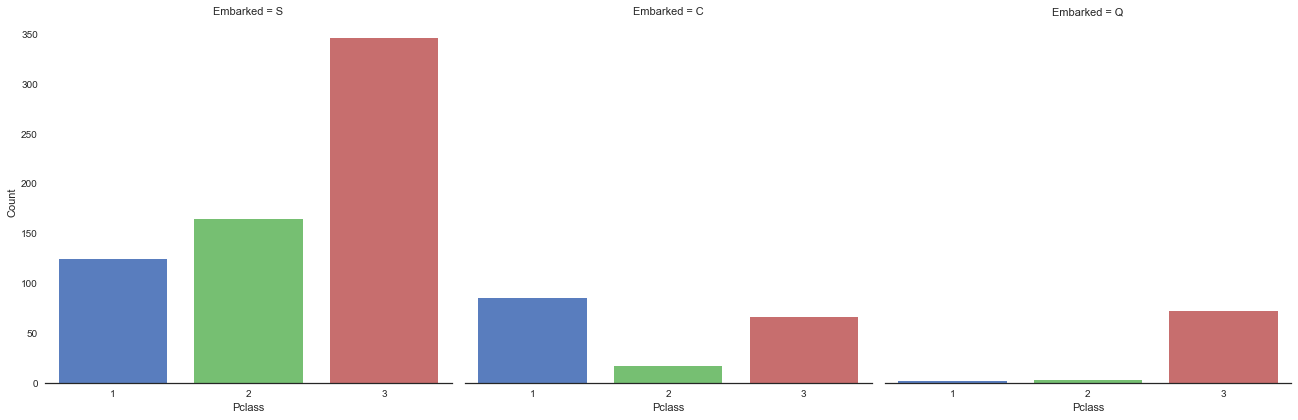

In [29]:
# Explore Pclass vs Embarked 
g = sns.factorplot("Pclass", col="Embarked",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

Indeed, C has a high percentage of 1st class passengers

# 3) Feature engineering

## 3.1) Title

In [30]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

The Name variable contains information about a passenger's first name, surname, and most importantly their title.

In [31]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

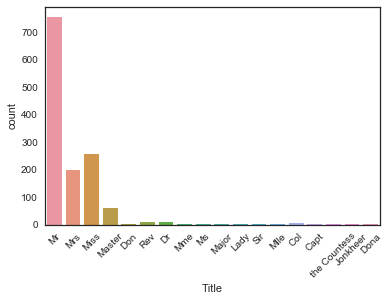

In [32]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

We can see that we have the following titles:

**Master**: indicating a minor male

**Mrs, Miss, Ms, Mme, Mlle**: indicating both minor and adult females

**Mr**: Indicating adult males

**Unique titles**: Indicating important passengers who may have been prioritized during the evacuation

In [33]:
# Group titles: master (minor male), Mr (adult male), Miss (unmarried female), Mrs (married female), Royal, Officer 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Don','Sir', 'Jonkheer', 'Dona'], 'Royal')
dataset["Title"] = dataset["Title"].replace(['Capt', 'Col','Dr', 'Major', 'Rev'], 'Officer')
dataset["Title"] = dataset["Title"].replace(['Miss', 'Mlle'], 'Miss')
dataset["Title"] = dataset["Title"].replace(['Mrs', 'Ms','Mme'], 'Mrs')

In [35]:
dataset.Title.value_counts()

Mr         753
Miss       257
Mrs        200
Master      60
Officer     23
Royal        6
Name: Title, dtype: int64

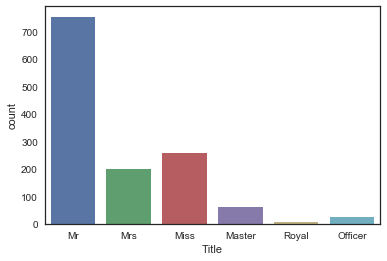

In [37]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Mr","Mrs","Miss","Master","Royal","Officer"])

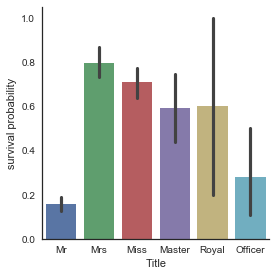

In [38]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Mr","Mrs","Miss","Master","Royal","Officer"])
g = g.set_ylabels("survival probability")

Extracting the titles was a worthwhile endeavour, we can clearly see that women, children, and royalty, have much higher survival rates. 

In [39]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

In [40]:
dataset = pd.get_dummies(dataset, columns = ["Title"],prefix="Title")

## 3.2) Family size

Creating a new feature based on the size of a passenger's entourage (siblings, parents, children)

In [41]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

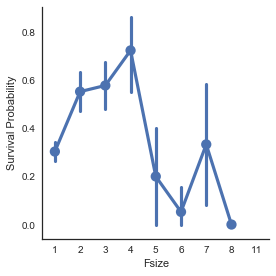

In [42]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

We can see that being alone or having a large family negatively impacts survival rates. Groups of 2-4 had better survival rates.

In [43]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if 2 <= s <= 4  else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

We have split passengers into 3 groups:

Single

Small family (2-4)

Large family (>=5)

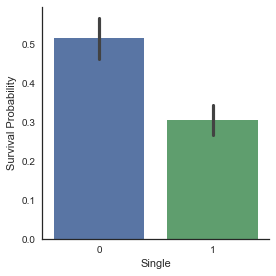

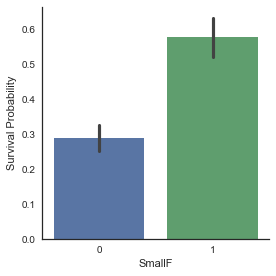

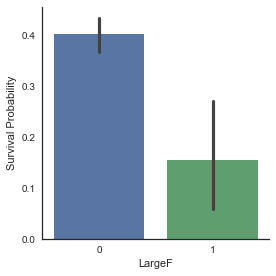

In [44]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

We can see that survival rates are indeed affected by the size of a passenger's entourage.

## 3.3) Cabin

As previously mentioned, the Cabin variable contains a large proportion of NaN (1007)

The Cabin variable is an alphanumeric sequence which indicates the deck of a passenger. We will assign all NaN a deck of X signifying unknown. 

In [45]:
# Replace the Cabin number by the type of cabin 'U' for unknown if NaN, extract the deck letter for all other passengers
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'U' for i in dataset['Cabin'] ])

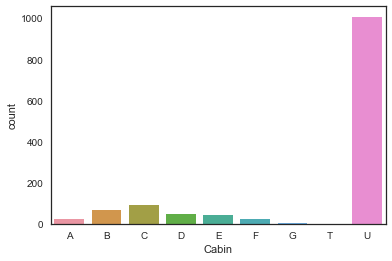

In [47]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','U'])

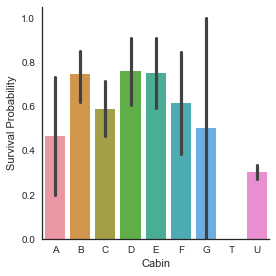

In [48]:
g = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','U'])
g = g.set_ylabels("Survival Probability")

Due to a low sample size many decks have very large standard deviations. However, we can see that passengers staying on decks B, C, D, E, and F, have good survival rates.

## 3.4) Ticket

In [50]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

The ticket prefix indicates the location of a passenger, we will use the same method as before in order to extract this information. We assign an X when location is unknown.

In [51]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [52]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="Ticket")

In [53]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pclass")

In [54]:
#Create categorical values for Embarked
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Embarked")

In [59]:
#Create categorical values for Cabin
dataset = pd.get_dummies(dataset, columns = ["Cabin"], prefix="Cabin")

In [55]:
# Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [60]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royal,Fsize,Single,SmallF,LargeF,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X,Pc_1,Pc_2,Pc_3,Emb_C,Emb_Q,Emb_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,22.0,1.981001,0,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,38.0,4.266662,0,1,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26.0,2.070022,0,1,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,35.0,3.972177,0,1,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35.0,2.085672,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Thus, the final dataset contains 68 variables.

# 4) Model

## 4.1) Exploring feature importance

In [63]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

In [92]:
## Separate train features and label 

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

In [93]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X_train, Y_train)

In [94]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

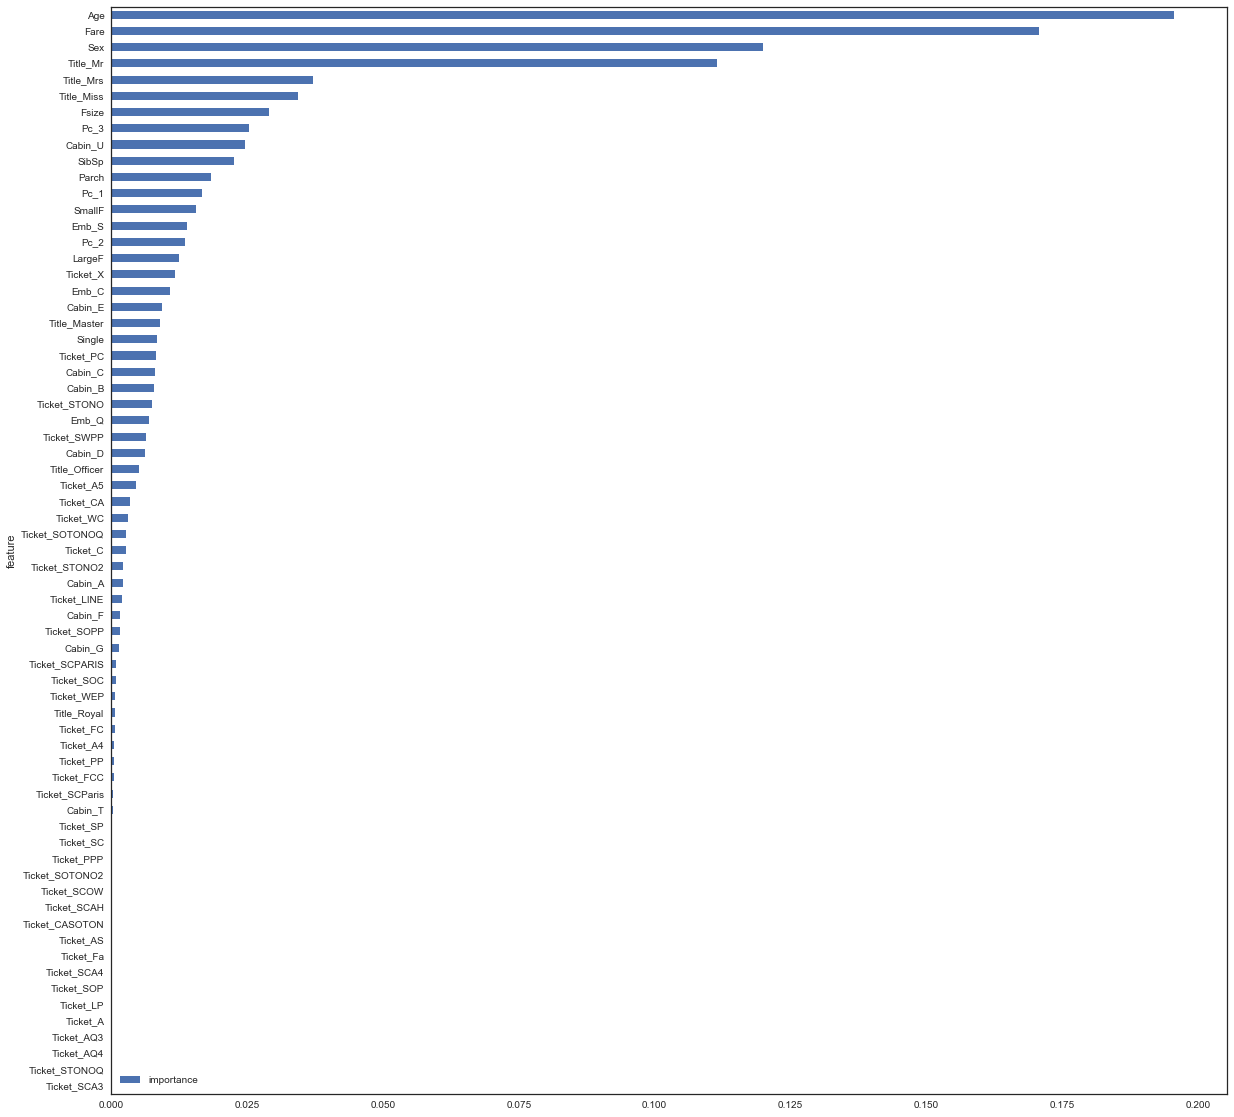

In [71]:
features.plot(kind='barh', figsize=(20, 20))

We can see that the random forest classifier attributes the most importance to Age, Fare, Sex, and Title_Mr.

## 4.2) Parameter optimization

In [96]:
# turn run_gs to True if you want to run the gridsearch again.
run_gs = False

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8, 10],
                 'n_estimators': [1000, 500, 100, 50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 5, 10],
                 'min_samples_leaf': [1, 3, 5, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(Y_train, n_folds=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation)

    grid_search.fit(X_train, Y_train)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 50, 
                  'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 6,
                 'n_jobs' : -1}
    
    model = RandomForestClassifier(**parameters)
    model.fit(X_train, Y_train)

Here we have run a comprehensive gridsearch in order to optimize the parameters of our model.

## 4.3) Final model output

In [101]:
results_df = pd.read_csv("test.csv")
results_df = results_df.drop(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis=1)

In [104]:
results_df['Survived'] = model.predict(test)

In [105]:
results_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [106]:
results_df.to_csv("FINAL_KAGGLE_TITANIC_ENTRY.csv", index=False)

This model had an accuracy score of 0.78947 on kaggle's unseen test data.